<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle


####  we have 9437518 no of egde between the different pair of vertices and 2 here is the column number

In [2]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    # Read a graph from a list of edges.
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

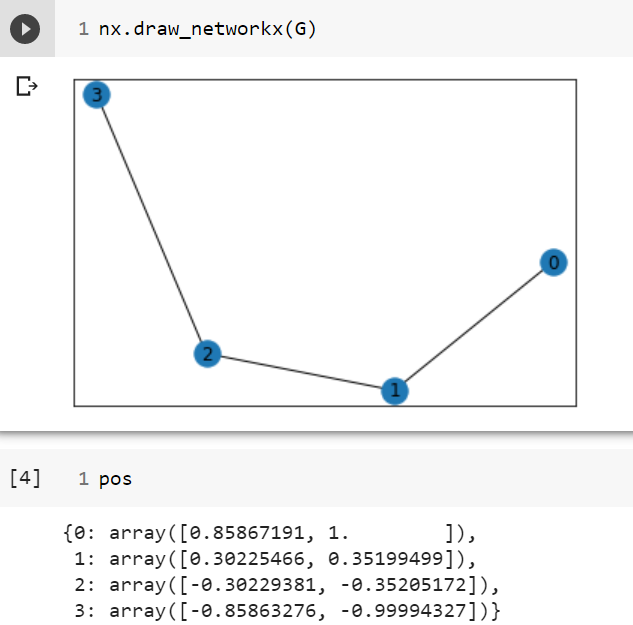

import networkx as nx

G = nx.path_graph(4)
pos = nx.spring_layout(G)

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


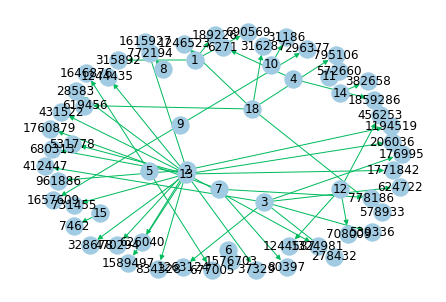

In [3]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

# spring layout gives the position(cordinates of x and y) of each nodes for ex: node = [x-axis value , y-axis value]
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [4]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

#  we have 9437518 no of egde between the different pair of vertices and 2 here is the column number

The number of unique persons 1862220


## 1.1 No of followers for each person

In [5]:
# g.in_degree()

# key represent the node/person and value store the number of followers of node/person

# ({1: 3, 690569: 29, 315892: 28, ....})

In [6]:
#  list(dict(g.in_degree()).values())

# [3,29,28,3,4, .....]

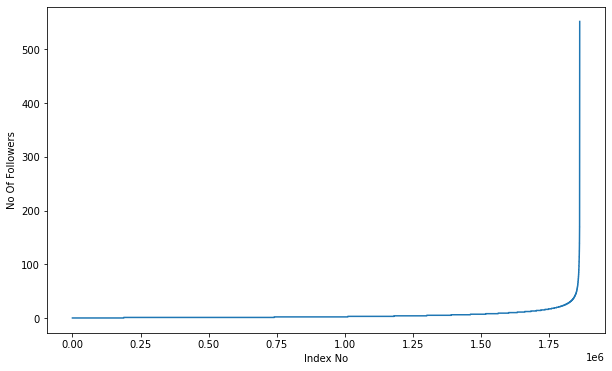

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()


# there are 1750000 people havign followers close to 0. 
# there is 1 person who is having more than 500 number of followers 

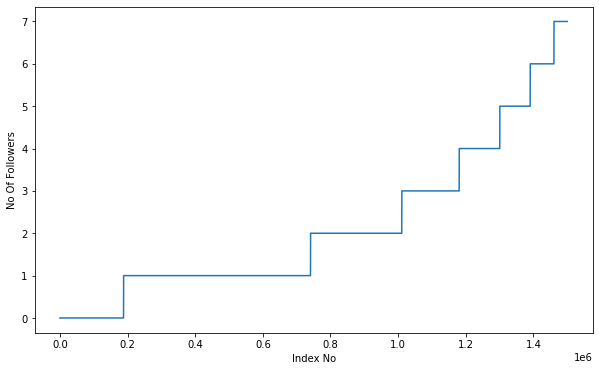

In [8]:
# we are intrperating the small part of user having number of followers (indgreee)

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()


#### observation

# 1) there are 20000 people having 0 followers 
# 2) there are 40000 people having 1 followers
# 3) there are 20000 people having 2 followers
# 4) .. so we can intrepret the number of people haivng number of followers 

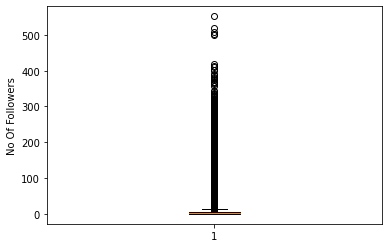

In [9]:
# observation :- many people are having close to 0 followers 

plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [10]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))
    
    
# 90% of person have 12 followers 
# 91% of person have 13 followers 
# .. so on 

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

In [11]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))
    
# 99.9% of data haivng followers 112 only

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


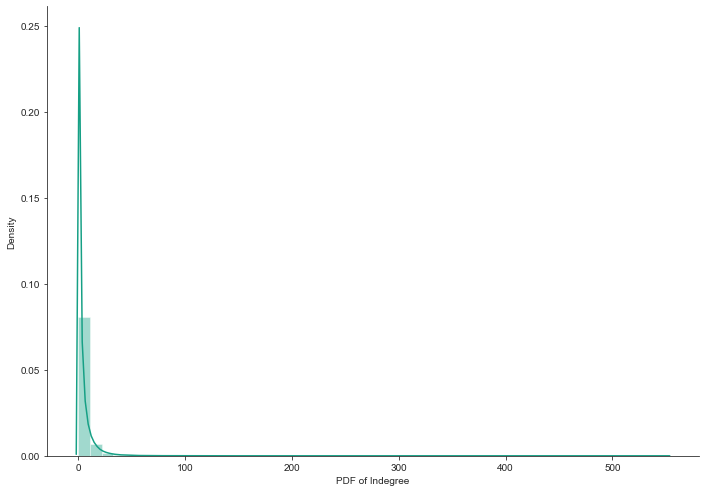

In [12]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()


# observation :- same as above

## 1.2 No of people each person is following

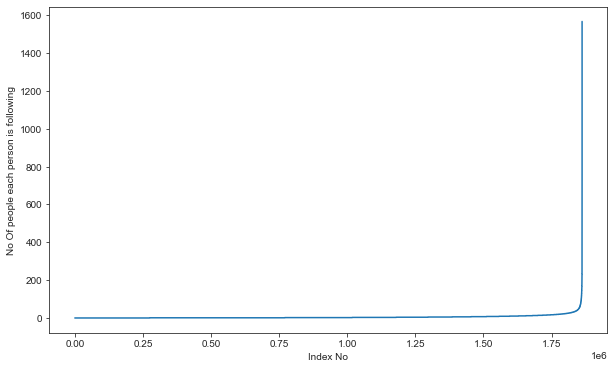

In [13]:
# observation :- 1750000 of person have almost close to 0 followers



outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show() 



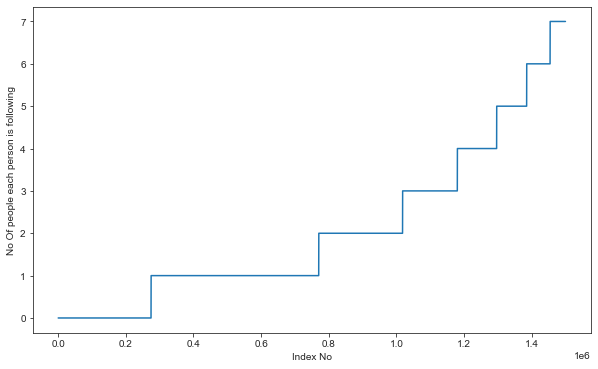

In [14]:
# observation :- 
# 1) 230000 of people is following 0 only 
# 2) 600000 of people is following 1 only 
# 3) 200000 of people is following 2 only 

outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

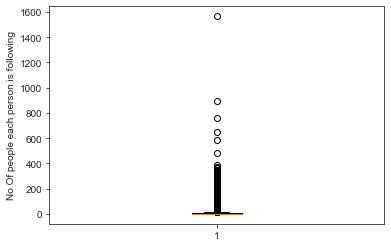

In [15]:
plt.boxplot(outdegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [16]:
#new_dict=dict(g.out_degree())  # it gives the number of person following by each person (person number,#of people he is following)
#new_dict.values()  # it gives the value/number of people following by each user 


In [17]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [18]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


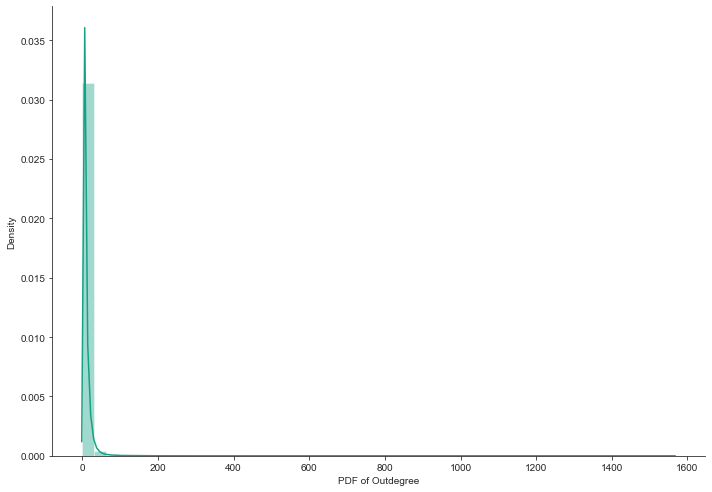

In [19]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [20]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [21]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [22]:
# here we are finding the number of user/node having no followers and no followees


###     m -> n 

# # A predecessor of n is a node m such that there exists a directed edge from m to n.**** predcessor means followers of u
# # A successor of n is a node m such that there exists a directed edge from n to m. **** successor means followees of u 

###  n -> m 

count=0
# for each nodes in data/graph 
for i in g.nodes():
# Returns an iterator over successor nodes of n.
    if len(list(g.predecessors(i)))==0 :
# Returns an iterator over predecessor nodes of n.
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following 

In [23]:
from collections import Counter

# collect the number of followers of each node/user and store them in dict type
dict_in = dict(g.in_degree())

# collect the number of followees of each node/user and store them in dict type
dict_out = dict(g.out_degree())

# len(dict_in)  # so dict_in containsnumber of followers for 1862220 user i.e. unique user as we know there 1862220 unique user
    
#  sum up the number of followers and followees of each user 
d = Counter(dict_in) + Counter(dict_out)

# convert in array  
in_out_degree = np.array(list(d.values()))

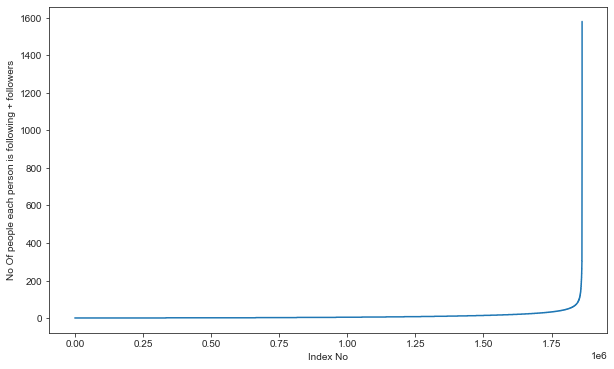

In [24]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

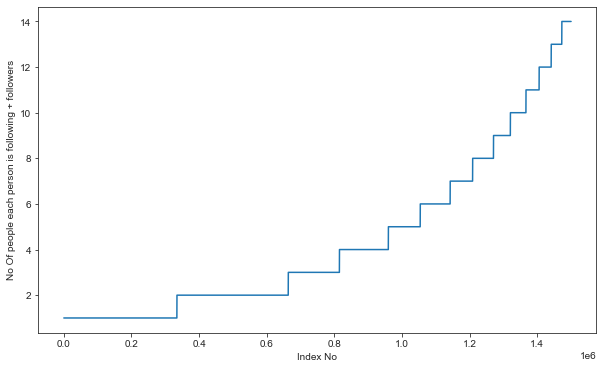

In [25]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [26]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [27]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [28]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [29]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [30]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [31]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [32]:
# it contians the pair of nodes having edges between them 

r = csv.reader(open('data/after_eda/train_woheader.csv','r'))


for i in r:
    print(i)
    break


# set the connection = 1 between the edges(pair of nodes/user)present in our data. 
    
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

    
# output : ['1', '690569'] 
# ('1', '315892'): 1,
# ('1', '189226'): 1,
# ('2', '834328'): 1,
# ('2', '1615927'): 1,
# ('2', '1194519'): 1 

['1', '690569']


In [33]:
%%time
###generating bad edges from given graph ***** ( bad edges means no edge)
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        # It is making the connection set = 1 between the set of edges
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        
# get the 2 number number for pair of vertices 
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        
# if this pair of vertices is already present in data get the value else return edge = -1
        tmp = edges.get((a,b),-1)
    
# if there is no edge between the pair of vertices that we are generating and if node are not same then check if shortest 
# distance between the a and b > 2 or not . if greater than 2 add that pair of vertices in the missing edges  
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2:      
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
# store the missing edge in missing edge final 
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
#pickle has two main methods. The first one is dump , which dumps an object to a file object and the second one is load ,
# which loads an object from a file object 
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

Wall time: 4.63 s


In [34]:
len(missing_edges)

# there are 9437519 number of pair of vertices where there is no edge 
# there are 9437519 number of pair of vertices having an edge 

# we have kept equal number of datapoint for each class i.e. no edge(0) and having edge(1)
# means 

#    no of datapoints having an edge = number of datapoints having no edges

9437519

In [35]:
missing_edges   # it contains the pair of vertices that do not have edge between them 

{(601436, 1322692),
 (891928, 411442),
 (114606, 1845732),
 (669241, 486296),
 (941565, 676512),
 (886515, 666437),
 (1531834, 1045279),
 (532244, 887754),
 (826742, 803876),
 (992702, 1004464),
 (470241, 304412),
 (923940, 865240),
 (299292, 580155),
 (1285487, 812420),
 (772968, 478129),
 (709426, 1590709),
 (171165, 587343),
 (179058, 820372),
 (303384, 1245193),
 (750989, 636333),
 (1544989, 300509),
 (498086, 1698685),
 (1665402, 904893),
 (1118049, 774446),
 (1537308, 1055113),
 (1262718, 479543),
 (1323580, 613557),
 (1616245, 116356),
 (1127800, 137112),
 (1349449, 839499),
 (1703797, 1759845),
 (773282, 317625),
 (1276799, 616525),
 (727094, 1656457),
 (1046304, 1512592),
 (1761611, 1071091),
 (304933, 1594376),
 (980094, 1138822),
 (1602769, 619077),
 (1306181, 1771972),
 (1099334, 828882),
 (186719, 638632),
 (1589047, 801747),
 (1316920, 1652913),
 (802465, 11150),
 (1534803, 767525),
 (1220492, 996114),
 (1266656, 46411),
 (1541817, 1013504),
 (547650, 1175673),
 (1372743,

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

Now we will split the D1 into train , test similarly split the D2 into train and test now now we will merge the D1 train and D2 train to make complete D_train.Same for D2_test.

In [36]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df

    # train.csv contains the pair of vertices having an edge 
    df_pos = pd.read_csv('data/train.csv')
    
    # converting the missing edge data into dataframe and denote it as df_neg 
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    
    # we have to 2 dataframe df_pos will contains the data having an egdes 
    # df_neg will contains data having no edges 
    
    # as we know to apply a classification algorithm/model on data first needs to have binary(0/1) class label datapoint
    # we have both datapoints of each class in equal number i.e. balanced dataset  
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    # np.ones(len(df_pos)) : will generate the array of size =9437519 contianing 0  i.e. y class label for datapoint in df_pos
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    
    # np.zeroes : will generate the array of size(df_neg)= 9437519 containing 1 i.e y class label for datapoint in df_neg
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [37]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


we will be facing the cold start problem becuase 7% of datapoint/person/vertices are test but not in train  

> we have a cold start problem here

In [38]:
#final train and test data sets
#if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
#(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
#(not os.path.isfile('data/train_y.csv')) and \
#(not os.path.isfile('data/test_y.csv')) and \
#(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
#(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
#(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
#(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    

if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    # x train pos contains the training data that have class=1/edge       datapoint/vertices/people
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    # x train neg contians the training data that have class=-1/0 / no edge     datapoint/vertices/people
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    # test datset contaning datapoint having no edge/class =0 
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])
    
    # combine the training datapoint having class =0 and 1 and store it in X train
    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    # class label of X train 
    y_train = np.concatenate((y_train_pos,y_train_neg))
    # combine the test datapoints having class = 0  and 1 and store it in X_test
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    # class label of X_test
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    
    # we have final training and test data i.e. X_train and X_test
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [39]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


In [40]:
# computed and store the data for featurization
# please check out FB_featurization.ipynb

In [41]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb




In [42]:
import warnings
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}


In [43]:
#for followees
# jaccard similarity is also known as jaccard index not jacard distance. To calculate jacard distance = 1- jaccard index
# let u1 -> u2 
# predcessor(u1) it gives the vertex/node of followers of u1 
# successor(u2) it gives the vertex/node of followees by u2


# predcessor(u) means followers of u (indegree)
# successor(u) means followees of u  (outdegree)


###                                           sim store the similarity value 

def jaccard_for_followees(a,b):
    try:
      # if there is no followers of either a or b then return 0 ( means there is 100 % chance that they will not follow each other )
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        # calculate the jacc_similarity
        # find the number of common fololowers of a and b / total number of unique followers of a and b
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

# |X U Y| :--- it means total number of unique followers/followees of both a and b 
# |X interesection Y| means number of common followers/followees of a and b 

In [44]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [45]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [46]:
#for followers
def jaccard_for_followers(a,b):
    try:
       # if there is no followers of either a or b then return 0 ( means there is 100 % chance that they will not follow each other )
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        # find jaccard similarity 
        # fidn the number of common followers by a and b / total number of unique followers by a and b 
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [47]:
print(jaccard_for_followers(273084,470294))

0.0


In [48]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [49]:
#for followees



def cosine_for_followees(a,b):
    try:
      # if there is no followees of either a or b then return 0 ( means there is 100 % chance that they will not follow each other 
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
      # calculate the cosine distance 
      # find the number of common followees of a and b / number of followees of a * number of followees of b 
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [50]:
print(cosine_for_followees(273084,1505602))

0.0


In [51]:
print(cosine_for_followees(273084,1635354))

0


In [52]:
def cosine_for_followers(a,b):
    try:
        # if there is no followers of either a or b then return 0 ( means there is 100 % chance that they will not follow each other )
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        # calculate the cosine similarity 
        # find the number of common followers of a and b / number of followers of a * number of followers of b 
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [53]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [54]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>


### 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank

QUES) why use only positive datapoint to for paegrank, daccard simmilairty , cosine similarity ?

because pagerank depends on present links/edges right. if their is no edge between two nodes then it doesnot add any value to final result. so while computing page rank we use only positive edges. but while adding this page rank feature we add this to all the points both positive and negative for negative edges we use mean of page rank of positive edges


In [55]:
# we are finding the page rank score for the pair of nodes having edge 
# train_graph contains the data having class = 1 and class= 0 also (class = 0 means no edge , class = 1 means having edge )


if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

In [56]:
# gives largest , min , average value of page rank score provided to nodes 

print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [57]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 4. Other Graph Features

## 4.1 Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.


In [58]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
    # if there is direct edge remove the edge and then calculate the shortesrt path and again add the original value btw a,b
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
    # if no direct edge calculate the shortest path
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    # if there is no edge between a,b then shortest path = -1
    except:
        return -1

In [59]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [60]:
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [61]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [62]:
belongs_to_same_wcc(861, 1659750)

0

In [63]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [64]:
#adar index

def calc_adar_in(a,b):
    sum=0
    try:
        # find the list of common nodes of a and b.
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [65]:
calc_adar_in(1,189226)

0

In [66]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [67]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [68]:
follows_back(1,189226)

1

In [69]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [70]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.025,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))
    

In [71]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [72]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

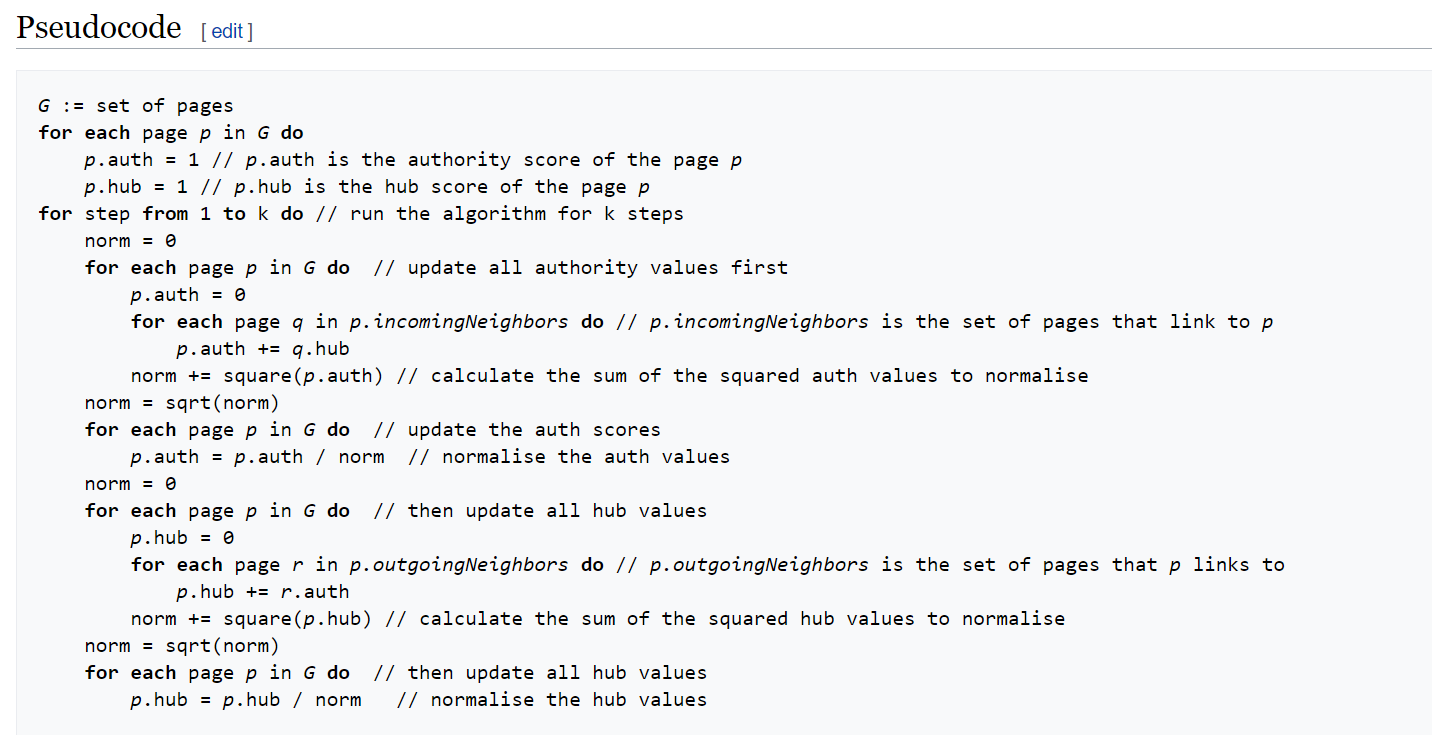


http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html

In [73]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [74]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [75]:
import random 

if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [76]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [77]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [78]:
# add the indicator_link as the columns which acts a yi(class label) for xi's 


df_final_train= pd.read_csv('data/after_eda/train_after_eda.csv',skiprows=skip_train,names=['source_node','destination_node'])
df_final_train['indicator_link']=pd.read_csv('data/train_y.csv',skiprows=skip_train,names=['indicator_link'])
print('our final train data',df_final_train.shape)
df_final_train.head()

our final train data (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,708359,888200,1
2,1036019,9238,1
3,177992,1392783,1
4,979020,485390,1


In [79]:
# add the indicator_link in the columns whihc acts a class label(yi) for all xi's

df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv',skiprows=skip_test,names=['source_node','destination_node'])
df_final_test['indicator_link']=pd.read_csv('data/test_y.csv',skiprows=skip_test,names=['indicator_link'])
print('our final test data',df_final_test.shape)
df_final_test.head()


our final test data (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,557644,1022502,1
2,778316,1277021,1
3,851720,817616,1
4,1537185,963662,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [80]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    
    # We can use the apply() function to apply the lambda function to both rows and columns of a dataframe. 
    # If the axis argument in the apply() function is 0, then the lambda function gets applied to each column, and 
    # if 1, then the function gets applied to each row.
    
    
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [81]:
def compute_features_stage1(df_final):
   # compute the number of followers, followees of source node and destination nodes 
    # compute the number of intersection/common number of followers , followees for source node and destination node 

    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]

    for i,row in df_final.iterrows():
        try:
            # compute the list of incoming link for each source node 
            s1=set(train_graph.predecessors(row['source_node']))
            # compute the list of outgoing link for each source node
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 =set()
            s2 = set()
        try:
            # compute the lsit of incoming link for each destination node 
            d1 = set(train_graph.predecessors(row['destination_node']))
            # compute the list of outgoing link for each destination node/user
            d2= set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
            
        # add the number of followers i num_followers and num of followes of source node in num_followees
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))
    
        # add the number of followers of destination node in num_followers and num of_followees of destintion node in num_followees
        num_followers_d.append(d1)
        num_followees_d.append(d2)
    
        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [82]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [83]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    
    # map the adar index to train data
    df_final_train['adar_index'] = df_final_train.apply(lambda row:
                                            calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    # map the adar index to test data 
    df_final_test['adar_index']=df_final_test.apply(lambda row:
                                            calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    
    # map the is follwoing back to train data
    df_final_train['is_following_back'] = df_final_train.apply(lambda row:
                                            follows_back(row['source_node'],row['destination_node']),axis=1)
    # map the is following back to test data 
    df_final_test['is_following_back']=df_final_test.apply(lambda row:
                                            follows_back(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    
    
    # mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: 
                                            belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    # mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: 
                                            belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    
    
    # mapping shortest path between soruce and destination node 
    df_final_train['shortest_path '] = df_final_train.apply(lambda row:
                                            compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    # map the adar index to test data 
    df_final_test['shortest_path']=df_final_test.apply(lambda row:
                                            compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>


#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}


it is directed graph so calculated Weighted in and Weighted out differently

In [84]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████████████████████████████████████████████████████████████████| 1780722/1780722 [04:28<00:00, 6643.71it/s]


In [85]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [86]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [87]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [88]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
Adj.shape

In [ ]:
print(Adj[:10])   # it gives the similarity matrix i.e.

In [ ]:
U, s ,V = svds(Adj, k=6)
print('ajdency matrix shape',Adj.shape)
print('U shape',U.shape)
print('s shape',s.shape)
print('v shape',V.shape)



In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.head(2)

In [ ]:
# df_Final_train_copy will be used later for xgboost hypereparameter tuning 

df_final_train_copy = df_final_train
df_final_test_copy = df_final_test

In [ ]:
df_final_train.to_csv('data/after_eda/final_train.csv', encoding='utf-8', index=False)
df_final_test.to_csv('data/after_eda/final_test.csv',encoding='utf-8',index=False)



In [ ]:
df_final_train= pd.read_csv('data/after_eda/final_train.csv')
df_final_test= pd.read_csv('data/after_eda/final_test.csv')

In [ ]:
df_final_train.shape

In [ ]:
df_final_train_copy = df_final_train
df_final_test_copy= df_final_test

In [ ]:
df_final_train_copy.shape

# Models 

In [ ]:
df_final_train.columns

In [ ]:
print(df_final_train.shape)


In [ ]:
y_train = df_final_train['indicator_link']
y_test  = df_final_test['indicator_link']

df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)


In [ ]:
# buidl th random forest model with n_estimator and depth as hyperparameter 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

estimator = [10,50,100,250,450]

train_scores=[]
test_scores=[]

for i in estimator:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc= f1_score(y_test,clf.predict(df_final_test))
    
    train_scores.append(train_sc)
    test_scores.append(test_sc)
    
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimator,train_scores,label='Train Score')
plt.plot(estimator,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

In [ ]:
print(rf_random.best_estimator_)

In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
df_final_train_copy = pd.read_csv('data/after_eda/final_train.csv')
df_final_test_copy = pd.read_csv('data/after_eda/final_test.csv')

# adding svd_dot

it is calculated as dot product between the source node svd and destinaion node svd feature 

In [ ]:
df_final_train_copy['svd_dot_u']=(df_final_train_copy['svd_u_s_1']*df_final_train_copy['svd_u_d_1'])+\
(df_final_train_copy['svd_u_s_2']*df_final_train_copy['svd_u_d_2'])+\
(df_final_train_copy['svd_u_s_3']*df_final_train_copy['svd_u_d_3'])+\
(df_final_train_copy['svd_u_s_4']*df_final_train_copy['svd_u_d_4'])+\
(df_final_train_copy['svd_u_s_5']*df_final_train_copy['svd_u_d_5'])+\
(df_final_train_copy['svd_u_s_6']*df_final_train_copy['svd_u_d_6'])

df_final_train_copy['svd_dot_v']=(df_final_train_copy['svd_v_s_1']*df_final_train_copy['svd_v_d_1'])+\
(df_final_train_copy['svd_v_s_2']*df_final_train_copy['svd_v_d_2'])+\
(df_final_train_copy['svd_v_s_3']*df_final_train_copy['svd_v_d_3'])+\
(df_final_train_copy['svd_v_s_4']*df_final_train_copy['svd_v_d_4'])+\
(df_final_train_copy['svd_v_s_5']*df_final_train_copy['svd_v_d_5'])+\
(df_final_train_copy['svd_v_s_6']*df_final_train_copy['svd_v_d_6'])




# ===================================================================================

df_final_test_copy['svd_dot_u'] = (df_final_test_copy['svd_u_s_1']*df_final_test_copy['svd_u_d_1'])+\
(df_final_test_copy['svd_u_s_2']*df_final_test_copy['svd_u_d_2'])+\
(df_final_test_copy['svd_u_s_3']*df_final_test_copy['svd_u_d_3'])+\
(df_final_test_copy['svd_u_s_4']*df_final_test_copy['svd_u_d_4'])+\
(df_final_test_copy['svd_u_s_5']*df_final_test_copy['svd_u_d_5'])+\
(df_final_test_copy['svd_u_s_6']*df_final_test_copy['svd_u_d_6'])


df_final_test_copy['svd_dot_v']=(df_final_test_copy['svd_v_s_1']*df_final_test_copy['svd_v_d_1'])+\
(df_final_test_copy['svd_v_s_2']*df_final_test_copy['svd_v_d_2'])+\
(df_final_test_copy['svd_v_s_3']*df_final_test_copy['svd_v_d_3'])+\
(df_final_test_copy['svd_v_s_4']*df_final_test_copy['svd_v_d_4'])+\
(df_final_test_copy['svd_v_s_5']*df_final_test_copy['svd_v_d_5'])+\
(df_final_test_copy['svd_v_s_6']*df_final_test_copy['svd_v_d_6'])




In [ ]:
df_final_train_copy.head(2)

# Adding Preferential Attachment feature 

https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/preferential-attachment/


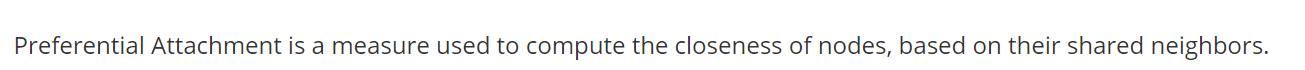

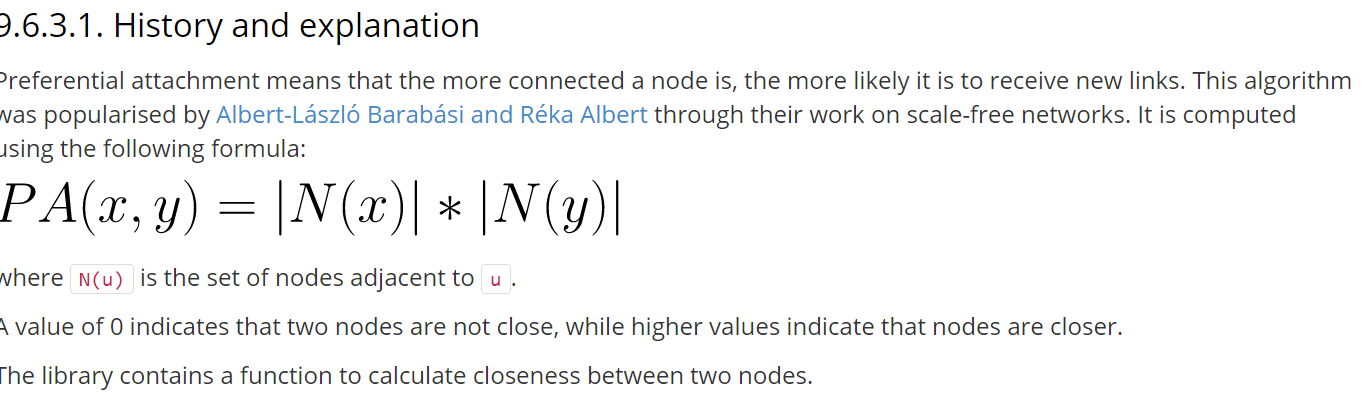

In [ ]:
def compute_perf_attach(df_final):
    
    perf_attach_followers=[]
    perf_attach_followees=[]
    
    for i,row in df_final.iterrows():
        try:
        # compute product of followees of source node and destination node 
            fe1 =set(train_graph.successors(row['source_node']))
            fe2 =set(train_graph.successors(row['destination_node']))
            product1  = len(fe1)*len(fe2)
        except:
            fe1=0
            fe2=0
            product1 = 0
        
    # compute product of followers of source node and destination node
        try:
            fo1 = set(train_graph.predecessors(row['source_node']))
            fo2 =set(train_graph.predecessors(row['destination_node']))
            product2 = len(fo1)*len(fo2)
        except:
            fo1=0
            fo2=0
            product2=0
    
        perf_attach_followees.append(product1)
        perf_attach_followers.append(product2)
        
    return perf_attach_followers,perf_attach_followees
        
        

In [ ]:

    
# map the perferential attachment feature to training data and testing data

df_final_train_copy['perf_attachment_followers'],df_final_train_copy['perf_attachment_followees'] = compute_perf_attach(df_final_train_copy)

df_final_test_copy['perf_attachment_followers'],df_final_test_copy['perf_attachment_followees'] = compute_perf_attach(df_final_test_copy)


In [ ]:
df_final_train_copy.head(2)

# Xgboost with hyperparameter tuning 


In [ ]:
df_final_train_copy.shape

In [ ]:
df_final_test_copy.shape

In [ ]:
import xgboost as xgb
from xgboost import cv

In [ ]:
y_train = df_final_train_copy['indicator_link']
y_test  = df_final_test_copy['indicator_link']

df_final_train_copy.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test_copy.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)


In [ ]:
xgb_clf = xgb.XGBClassifier()
parameter={ 'learning_rate' :[0.1,0.2,0.3,0.4],
 'n_estimators':[10,50,100,150,200,],
 'alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'lambda':[1e-5, 1e-2, 0.1, 1, 100],
 'max_depth':[5,6,7,8,9],
 'min_child_weight':[1,3,5,7],
 'gamma':[0.1,0.3,0.5,0.7],
 'subsample':[0.5,0.6,0.7,0.8],
 'colsample_bytree':[0.5,0.6,0.7,0.8],
 'objective':['binary:logitraw'],
 'nthread':[4],
 'scale_pos_weight':[1],
 'seed':[27]
}

 
clf_2 = RandomizedSearchCV(xgb_clf,param_distributions=parameter,cv = 3,scoring='f1',n_jobs = 5,return_train_score=True)

clf_2.fit(df_final_train_copy,y_train)


In [ ]:
clf_2.best_score_

In [ ]:
clf_2.best_params_

In [ ]:
xgb_clf =xgb.XGBClassifier(subsample=  0.5, seed= 27,
 scale_pos_weight=1,
 objective = 'binary:logitraw',
 nthread = 4,
 n_estimators = 200,
 min_child_weight =5,
 max_depth= 9,
 learning_rate = 0.1,
 gamma = 0.3,
 colsample_bytree = 0.7,
 reg_lambda=1, 
 alpha = 0.01)

xgb_clf.fit(df_final_train_copy,y_train)
y_train_pred = xgb_clf.predict(df_final_train_copy)
y_test_pred = xgb_clf.predict(df_final_test_copy)


from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features=df_final_train_copy.columns
features

In [ ]:
df_final_train_copy.shape

In [ ]:
features = df_final_train_copy.columns
importances = xgb_clf.feature_importances_
indices = (np.argsort(importances))[-65:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
importances = xgb_clf.feature_importances_
importances

# Conclusion 

1) Given problem : we are given a social directed graph dataset and our task is to predict the missing link to recommend user  (link prediction)

2) our data contains the 2 columns i.e. source node and destination node . original data cotains only nodes that have an edge between them i.e. edge = 1 

3) Then performed EDA to get some insights about data such as 
        1) number of followers of each person
        2) number of people each person following
        3) No of persons those are not following anyone are
        4) No of persons having zero followers are
        5) Max number of followers + followees
        6) Min number of followers + followees
        7) Number of poeple having min number of followers+following
        8) Number of people havign max number of followers+following 
        
4) after performing EDA, then we generated some missing edge which were not present in our data because 
     In Our given data we are given only  9437519 number of pair of node having an edge i.e. edge = 1 
     But if we want to convert our problem into supervised problem we first has to balanced our data
     i.e. there should be equal no of datapoints of each class i.e. edge = 0 and edge =1 
     
     so we created the 9437519 number of pair of node having no edge i.e. edge = 0
     
5) performed featurations i..e created some new feature such as for both train and test data 

1.	jaccard_followers
2.	jaccard_followees
3.	cosine_followers
4.	cosine_followees
5.	num_followers_s
6.	num_followees_s
7.	num_followers_d
8.	num_followees_d
9.	inter_followers
10.	inter_followees
11.	adar index
12.	is following back
13.	belongs to same weakly connect components
14.	shortest path between source and destination
15.	Weight Features
1.	weight of incoming edges
2.	weight of outgoing edges
3.	weight of incoming edges + weight of outgoing edges
4.	weight of incoming edges * weight of outgoing edges
5.	2*weight of incoming edges + weight of outgoing edges
6.	weight of incoming edges + 2*weight of outgoing edges
16.	Page Ranking of source
17.	Page Ranking of dest
18.	katz of source
19.	katz of dest
20.	hubs of source
21.	hubs of dest
22.	authorities_s of source
23.	authorities_s of dest
24.	SVD features for both source and destination

6) using all the above created feature build the random forest model by finding the best value of parameter( n_estiamtor , max depth etc.) by performing hyperparamter tuning using randomsearchCv

    We achieve the F1 score for test data = 0.9241678239279553
    F1 score for train data  =  0.9652533106548414
    
7) In order to see increase in model performance we created and added new feature in train data and test data and used xgboost algorithm 
    
      New features are :  1) product of source node svd and destination node svd feature
                          2) perfertial attachment feature 
                          
     
     Build the xgboost model using all the previous + new features and perfomed hyperparamter tuning for xgboost 
    
     using the best value of parameter ( such as n_estimator , max depth , min_child_weight, lambda, gamma,   colsample_by_Tree) build the final xgboost model which gave very slight increase in model performance 
     
     i.e. F1 score on test data = 0.9278837962174136
     F1 score on train data = 0.9930341257476001
     
8) So perferntial attachment and product of source node svd and destination svd features does not help in increasing the model performance  
     
9) the most important features are: -  follow_back, cosine_followers, inter_followers,   jaccard_followees, cosine_followees,   weight_f1,    inter_followees, shortest_path,  